### Определение темы по постам группы вк

Будем собирать посты из группы "Лентач" во вконтакте с целью выявить тематику группы. Рассмотрим также на какие кластеры тем можно разбить посты.

In [1]:
import logging
import sys
import requests
import json
import datetime
from ast import literal_eval
import pandas as pd
import numpy as np
import configparser
import re
import nltk
from nltk.corpus import stopwords 
# from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
# lemma = WordNetLemmatizer()

import pymorphy2
morph = pymorphy2.MorphAnalyzer()

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package wordnet to /Users/mary/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/mary/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/mary/anaconda3/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


### 1. Сбор информации. 



In [2]:
def gather_process():

    # gather data and save as txt
    id_ = 'lentach'
    owner_id = '29534144'# lentach
    count = 40
    offset = -1

    # In access_token.ini we have token for vk
    config = configparser.ConfigParser()
    config.read('access_token.ini')
    access_token = config.get('settings', 'token')
    
    for _ in range(100):
        url = 'https://api.vk.com/method/wall.get?owner_id=-{}&count={}&offset={}&v=5.52&access_token={}'.format(
            owner_id, count, offset + 1, access_token)
        respond = requests.get(url)
        with open(id_ + str(_) + '.txt', 'w') as outfile:
            json.dump(respond.json(), outfile)
        
        offset += count

In [3]:
def convert_data_to_table_format():
    
    # transform gathered data from txt file to pandas DataFrame and save as csv
    id_ = 'lentach'
    
    for _ in range(40):
        file = id_ + str(_) + '.txt'
        result = literal_eval(open(file, 'r').read())
        ids = []
        dates = []
        comments = []
        likes = []
        reposts = []
        text = []

        for item in result['response']['items']:
            ids.append(item['id'])
            dates.append(datetime.datetime.fromtimestamp(item['date']))
            comments.append(item['comments']['count'])
            likes.append(item['likes']['count'])
            reposts.append(item['reposts']['count'])
            text.append(item['text'].encode('utf-16', 'surrogatepass').decode('utf-16'))

        df = pd.DataFrame({
            "id": ids,
            "date": dates,
            "comments_count": comments,
            "likes_count": likes,
            "reposts_count": reposts,
            "text": text,
        })
        df.to_csv(id_ + str(_) + '.csv', sep='\t')
    
    pass



In [4]:
# Take latest 4 000 posts of lentach
# gather_process()

In [5]:
# Convert to csv
convert_data_to_table_format()

In [101]:
# Create 1 df from 40 files
df = pd.concat([pd.read_csv(r'lentach' + str(i) + '.csv', sep='\t') for i in range(40)], axis=0)
df.shape

(4000, 7)

In [102]:
df[98:103]

,Unnamed: 0,id,date,comments_count,likes_count,reposts_count,text
98,98,11435352,2019-07-02 12:35:12,133,2793,11,Чехия сняла ограничения на полёты российских а...
99,99,11434988,2019-07-02 11:35:06,198,8598,204,В декабре 2018 года студент ВГИКа Артём Фирсан...
0,0,11434891,2019-07-02 11:20:00,43,373,6,• «Интерфакс»: число жертв паводка в Иркутской...
1,1,11434549,2019-07-02 10:36:15,199,5763,78,"Цены на свинину, говядину и мясо птицы в Росси..."
2,2,11434254,2019-07-02 09:34:23,288,1718,15,Сегодня утром власти Чехии запретили «Аэрофлот...


In [103]:
df = df.set_index('id')
df = df.drop(['Unnamed: 0'], axis=1)

In [104]:
df.head()

,date,comments_count,likes_count,reposts_count,text
id,,,,,
11460130,2019-07-06 16:13:03,92,1146,15,Список «ремейки фильмов с женщинами в главной ...
11459911,2019-07-06 15:33:47,155,1803,31,В России планируется своя «Википедия».\n\nПрав...
11459474,2019-07-06 14:17:03,168,6437,231,"А вы тоже в детстве двигали мышкой по экрану, ..."
11459119,2019-07-06 13:23:59,130,4821,141,Уже десять лет каждую первую субботу июля росс...
11458585,2019-07-06 12:11:06,681,5606,81,Основатель Amazon Джефф Безос официально развё...


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 11460130 to 10386610
Data columns (total 5 columns):
date              4000 non-null object
comments_count    4000 non-null int64
likes_count       4000 non-null int64
reposts_count     4000 non-null int64
text              3864 non-null object
dtypes: int64(3), object(2)
memory usage: 187.5+ KB


### 2. Обработка. 

* Удалим пропуски в значениях текста, т.к. никакая их обработка не поможет нашей цели
* Удалим русские стоп слова и знаки переноса строки (очистим текст)
* Разобьем каждый из текстов на отдельные слова
* Приведем слова к нормальной форме


In [106]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3864 entries, 11460130 to 10386610
Data columns (total 5 columns):
date              3864 non-null object
comments_count    3864 non-null int64
likes_count       3864 non-null int64
reposts_count     3864 non-null int64
text              3864 non-null object
dtypes: int64(3), object(2)
memory usage: 181.1+ KB


Добавим в перечень стоп слов те, что не несут особой смысловой нагрузки

In [339]:
stop_words = stopwords.words('russian')
stop_words.extend(['http', 'https', 'lenta', 'ch', 'cc', 'ow', 'news', 'vk', 'upd', 'the', 'id', 'ows',
                   'который', 'это', 'один', 'главный', 'свой', 'такой', 'лентач', 'ещё', 'еще', 'самый', 'тот', 'пока', 
                   'мол', 'некоторый', 'почему', 'отдельный', 'год', 'неделя', 'сегодня', 'впервые', 'будущий', 'оно',
                  'сразу', 'затем', 'этот', 'также', 'жаль', 'сейчас', 'поэтому', 'лаифкаха', 'ввод', 'вывод', 'broco', 'утро'
                  'последний', 'то', 'ничто', 'весь', 'стать', 'она', 'дать', 'хороший', 'весь', 'новый', 'имя', 'oqib',
                   'день', 'хотеть', 'большой', 'наш', 'узнать', 'очень', 'сделаться', 'просто', 'час', 'минута',
                   'назад', 'сюда', 'увеличиться', 'отдельный', 'полностью', 'перестать', 'иметь', 'owyt', 'проходить', 'июль',
                   'сделать', 'делать', 'читать', 'писать', 'число', 'считать', 'каждый', 'ряд', 'начало', 'конец', 
                   'пикчер', 'ваш', 'любой', 'снова', 'сколько', 'club', 'например', 'лишь', 'целый', 'начать', 'получить', 
                   'com', 'кстати', 'вместо', 'watch', 'один', 'два', 'три', 'четыре', 'пять', 'шесть', 'семь', 'восемь', 
                   'девять', 'десять','третье', 'мем', 'мема', 'слово', 'пара', 'январь', 'сегодня', 'суббота', 'ждать',
                   'ru', 'часто', 'тема', 'название', 'вокруг', 'oiahd', 'никто',  'остаться', 'сотня', 'сказать', 'называть', 
                   'предложение', 'представить', 'собираться', 'предложение', 'около', 'нужно', 'сильно', 'вокруг', 'март', 'именно', 
                   'отправить', 'получать', 'бывший', 'вчера', 'май', 'апрель', 'несколько', 'продолжать',
                   'взять', 'пройтись', 'использовать', 'почитать', 'вообще', 'рассказать', 'оказаться', 'rowp', 'ro', 'rrzf', 
                   'никак', 'хотя', 'rreq', 'grace', 'three'
#                    ,'ropr', 'практически', 'rrg', 'rofm'
                  ])
stop_words = set(stop_words)

In [340]:
def clean(text):
    # Remove garbage from lines
    text = re.sub(r'\n', ' ', text, flags=re.IGNORECASE)
    text = re.sub(r'•', '', text, flags=re.IGNORECASE)
    text = text.replace('ё','е')
    return text


def doc_to_words(doc, stop_words, morph):
    # remove stop words and punctuation + lemmatize
    words = [morph.parse(w)[0].normal_form for w in gensim.utils.simple_preprocess(str(doc), deacc=False) \
             if morph.parse(w)[0].normal_form not in stop_words]
    
#     # make lemmatization
#     words = [morph.parse(w)[0].normal_form for w in words if morph.parse(w)[0].normal_form not in stop_words]
    
    return words

In [341]:
# Clean and split by words

morph = pymorphy2.MorphAnalyzer()

data = df.text.values.tolist()
data = [clean(t) for t in data]
data_words = [doc_to_words(text, stop_words, morph) for text in data]

In [342]:
print(data[0])
print(data_words[0])

Список «ремейки фильмов с женщинами в главной роли» может пополниться еще одной картиной.  На этот раз в лучших традициях последних лет планируют переснять ту самую «Маску» с Джимом Кэрри  http://news.lenta.ch/Ow21
['список', 'ремейка', 'фильм', 'женщина', 'роль', 'мочь', 'пополниться', 'картина', 'традиция', 'последний', 'планировать', 'переснять', 'маска', 'джим', 'кэрри']


### 3. Построение моделей

* Найдем биграммы слов в каждом тексте
* Занумеруем биграммы (добавив им id) и посчитаем сколько раз то или иное слово встречалось внутри каждого текста (сделаем корпус)
* Попробуем разбить тексты на несколько тематик: построим зависимость когерентности от количества тематик; оптимальное число отобразим
* 

In [343]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=1, delimiter=b' ') # higher threshold fewer phrases.

bigram_mod = gensim.models.phrases.Phraser(bigram)    
data_words_bigrams = [bigram_mod[w] for w in data_words]

In [344]:
data_words_bigrams[100:110]

[['утром',
  'власть',
  'чехия',
  'запретить',
  'аэрофлот',
  'победа',
  'уральский',
  'авиалиния',
  'полёт',
  'страна',
  'источник',
  'интерфакс',
  'сообщить',
  'вина',
  'недовольство',
  'прага',
  'условие',
  'транссибирский',
  'маршрут',
  'чешский',
  'национальный',
  'перевозчик',
  'поздний',
  'руководитель',
  'уральский',
  'авиалиния',
  'сообщить',
  'авиакомпания',
  'возобновить',
  'полёт',
  'екатеринбург',
  'прага',
  'oq'],
 ['отмечаться всемирный',
  'нло',
  'уфолог',
  'случай',
  'принести',
  'текст',
  'амбициозный',
  'попытка',
  'человечество',
  'сконструировать',
  'летать',
  'тарелка'],
 ['право',
  'качнуть',
  'мочь',
  'качнуть',
  'качка',
  'включить',
  'губернатор',
  'красноярский край',
  'александр',
  'усс',
  'жительница',
  'затопить',
  'город',
  'спросить',
  'видеть',
  'местный',
  'дорога',
  'размыть',
  'yp',
  'tc'],
 ['soundgarden',
  'американский рок',
  'группа',
  'сиэтл',
  'образовать',
  'родоначальник',
  'ст

In [345]:
id2word = corpora.Dictionary(data_words_bigrams) # token to id (add ids to tokens)
corpus = [id2word.doc2bow(text) for text in data_words_bigrams] # create (token_id, token_count): 2-tuples

In [346]:
print(corpus[2])
print(id2word[67])

[(25, 1), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 2), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 5), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 4), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 3), (67, 2), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 3), (77, 1), (78, 2), (79, 1), (80, 1), (81, 1)]
система


In [347]:
# data[2].count('фоновый')

In [348]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics, 
            random_state=100,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto',
            per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [349]:
limit=120; start=2; step=5;
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_words_bigrams, 
                                                        start=start, 
                                                        limit=limit, 
                                                        step=step)

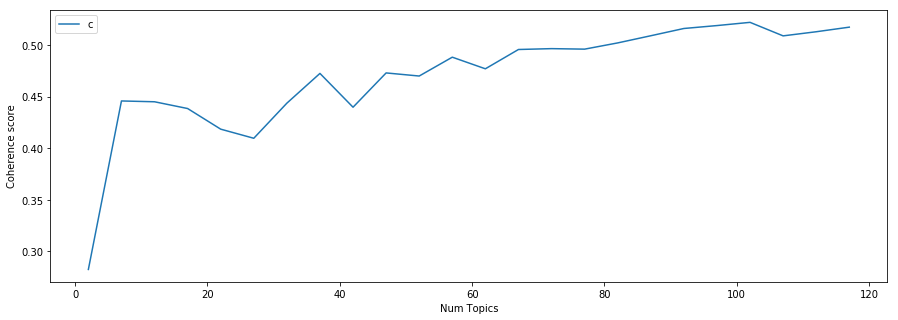

2:  0.2824058483332572
7:  0.4459373092719274
12:  0.4451462673738904
17:  0.438589952109736
22:  0.41856354455630274
27:  0.4097270723951542
32:  0.4437946014531407
37:  0.47266946267223686
42:  0.43986441031590523
47:  0.4731418310269665
52:  0.47013304451171817
57:  0.4884236513629661
62:  0.4771542850344652
67:  0.4958819420134193
72:  0.4967191167490203
77:  0.4962258904376896
82:  0.5022723501232148
87:  0.5092269781753147
92:  0.5162726879806588
97:  0.5191060498872501
102:  0.5222267862675477
107:  0.5091094021929291
112:  0.5131078963307054
117:  0.517567930879251


In [350]:
x = range(start, limit, step)
plt.figure(figsize=(15,5))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for i, j in enumerate(coherence_values):
    print(str(2 + i*5) + ':  ' + str(j))

Видно, что график начинает выходить на плато только после порога в 100 тем (лучшее значение в нашей разбивке с шагом 5 - 102 темы, скор 0.52). Попробуем разбить на 102 темы и на меньшее число (около 40):

In [359]:
lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=102, 
        random_state=100,
        update_every=1,
        chunksize=500,
        passes=50,
        alpha='auto');
pprint(lda_model.print_topics())

[(9,
  '0.078*"практически" + 0.000*"тренировка" + 0.000*"бегать" + '
  '0.000*"барнаульский" + 0.000*"постгранж" + 0.000*"подвести" + '
  '0.000*"тёплый" + 0.000*"размещать" + 0.000*"агенство" + 0.000*"пин"'),
 (46,
  '0.073*"нейросеть" + 0.054*"элемент" + 0.031*"научить" + 0.025*"фотошоп" + '
  '0.008*"обнаруживать" + 0.000*"постгранж" + 0.000*"телекомпания" + '
  '0.000*"размещать" + 0.000*"ночлег" + 0.000*"ropr"'),
 (42,
  '0.097*"официально" + 0.057*"планета" + 0.033*"супруг" + 0.017*"хватить" + '
  '0.000*"подвести" + 0.000*"тёплый" + 0.000*"тренировка" + '
  '0.000*"барнаульский" + 0.000*"пин" + 0.000*"visa"'),
 (41,
  '0.111*"дмитрий" + 0.042*"агентство" + 0.041*"предложить ввести" + '
  '0.034*"спортсмен" + 0.033*"всемирный" + 0.030*"употребление" + '
  '0.025*"строгий" + 0.024*"завести дело" + 0.021*"заподозрить" + '
  '0.013*"антидопинговый"'),
 (88,
  '0.099*"население" + 0.081*"крутой" + 0.061*"вич" + 0.039*"розыгрыш" + '
  '0.038*"согласно" + 0.030*"лето" + 0.027*"отчёт" 

In [360]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -47.78703395975886

Coherence Score:  0.42505484008566446


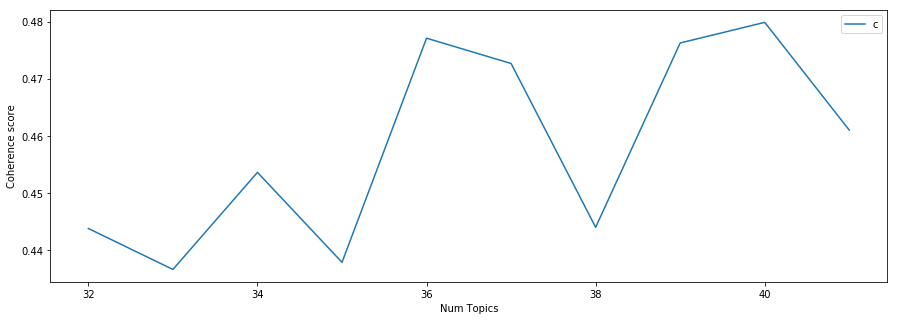

32:  0.4437946014531407
33:  0.43662784227072066
34:  0.4536197234145233
35:  0.4378739256495153
36:  0.47710233557771403
37:  0.47266946267223686
38:  0.4440012363136891
39:  0.47626281508710916
40:  0.4798717151959172
41:  0.46101051975559404


In [352]:
# 
limit=42; start=32; step=1;
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_words_bigrams, 
                                                        start=start, 
                                                        limit=limit, 
                                                        step=step)

x = range(start, limit, step)
plt.figure(figsize=(15,5))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for i, j in enumerate(coherence_values):
    print(str(start + i*step) + ':  ' + str(j))

In [357]:
lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=40, 
        random_state=100,
        update_every=1,
        chunksize=500,
        passes=50,
        alpha='auto');
pprint(lda_model.print_topics())

[(13,
  '0.036*"технология" + 0.033*"друг" + 0.030*"владелец" + 0.029*"современный" '
  '+ 0.027*"исследование" + 0.027*"бесплатный" + 0.024*"лекция" + '
  '0.023*"заставить" + 0.022*"клуб" + 0.021*"авария"'),
 (9,
  '0.051*"центр" + 0.045*"итог" + 0.035*"зеленский" + 0.031*"регистрация" + '
  '0.026*"кино" + 0.025*"килограмм" + 0.021*"кремль" + 0.021*"освободить" + '
  '0.021*"ссылка" + 0.013*"источник"'),
 (30,
  '0.056*"альбом" + 0.056*"выпустить" + 0.036*"радиолентач" + 0.036*"развитие" '
  '+ 0.030*"ровно" + 0.030*"мнение" + 0.023*"многий" + 0.022*"покинуть" + '
  '0.022*"минимум" + 0.018*"легендарный"'),
 (35,
  '0.061*"месяц" + 0.052*"часть" + 0.034*"прийтись" + 0.033*"знать" + '
  '0.027*"создание" + 0.027*"вырасти" + 0.024*"будущее" + 0.021*"включая" + '
  '0.018*"матерь" + 0.017*"победить"'),
 (28,
  '0.037*"смочь" + 0.028*"важный" + 0.025*"использование" + 0.023*"парень" + '
  '0.021*"путешествие" + 0.019*"сцена" + 0.018*"рождение" + 0.017*"оружие" + '
  '0.016*"родиться" + 

In [358]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -23.457996881481282

Coherence Score:  0.5031962474741307


Результат на 102 темах неплохой, но перплексия и когерентность на 40 лучше. Посмотрим теперь результат моделирования темы для паблика в целом

In [361]:
lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=1, 
        random_state=100,
        update_every=1,
        chunksize=500,
        passes=50,
        alpha='auto');

In [362]:
pprint(lda_model.print_topics())

[(0,
  '0.006*"новость" + 0.005*"россия" + 0.004*"человек" + 0.003*"время" + '
  '0.003*"мочь" + 0.002*"российский" + 0.002*"москва" + 0.002*"заявить" + '
  '0.002*"город" + 0.002*"власть"')]


In [363]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.003019930038707

Coherence Score:  0.18855212800915616


Получили похожий на правду результат: Лентач - новостной аггрегатор, рассказывающий о России и о том, как люди в ней живут. Для 1 группы: перплексия самая низкая (по модулю), но скор когерентности также самый маленький